## Nanopore TXN elongation model
Author: Robert Ietswaart, 20220818  
License: BSD2.  
Load modules j3dl and activate virtual environment using j4RNAdecay on O2.
Python v3.7.4, pytorch v1.4 

For Erik's project: perform nascent RNA modelling based on Nanopore 3' end sequencing.

source file: `Nanopore_RNA_model.ipynb`

`*_mito_read_to_transcript_mapping_no_spliced_reads.txt`
KC: The only reads that are filtered out in this file are those that show "splicing" events (e.g. the read starts in one gene, skips a bunch of genes and ends in another gene), which are likely alignment artifacts since there is no splicing in mitochondria

In [1]:
import os
import copy
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
from gtfparse import read_gtf
import seaborn as sns
from scipy.optimize import least_squares
from lmfit import minimize, Parameters

import fit

In [2]:
path = os.path.join('/n','groups','churchman','ri23','RNAdecay','TXN_model')

nano_reps = ['SEM2', 'SEM3']
deg_reps = ['TL3', 'TL4']

#load nanopore data
nano = dict()
genes = dict()
for r in nano_reps:
    filename = r + '_read_ends_coordinates.txt'
    nano[r] = pd.read_csv(os.path.join(path,'results_files',filename), sep='\t') 
    filename = r + '_mito_read_to_transcript_mapping_no_spliced_reads.txt'
    genes[r] = pd.read_csv(os.path.join(path,'results_files', filename), sep='\t') 
    
    
nano['merge'] = pd.concat([nano[nano_reps[0]], nano[nano_reps[1]]], ignore_index=True)
genes['merge'] = pd.concat([genes[nano_reps[0]], genes[nano_reps[1]]], ignore_index=True)

#load degradation rates
deg_rate = dict()
mapper = {'Fit1 (Ka)':'k', 'Gene':'symbol'}
for r in deg_reps:
    filename = r + '_MT_t5MTMMinformed6_modeAll_PcMTnorRNA_FracNew_halflives_corr_1592min.txt'
    deg_rate[r] = pd.read_csv(os.path.join(path, filename), sep='\t') 
    deg_rate[r].rename(mapper=mapper, axis=1, inplace=True)
deg_rate['mean'] = deg_rate[deg_reps[0]].drop(['Half Life', 'Normalized Half-Life'],axis=1)

#Drop MT-RNR1 because it was depleted using TLseq library prep
idx = deg_rate['mean'][deg_rate['mean']['symbol']=='MT-RNR1'].index
deg_rate['mean'].drop(idx,inplace=True)

deg_rate['mean']['k'] = np.sqrt(deg_rate[deg_reps[0]]['k'] *  deg_rate[deg_reps[1]]['k'])


filename = 'Hela_h_MT_MTmod.gtf'
gtf = read_gtf(os.path.join(path,filename)) 
# returns GTF with essential columns such as "feature", "seqname", "start", "end"
# alongside the names of any optional keys which appeared in the attribute column

genes_of_interest = set(deg_rate['mean'][deg_rate['mean']['symbol'].isin(gtf[gtf['strand']=='+']['gene_name'])]['symbol'])

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'transcript_id', 'transcript_version', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_name', 'transcript_source', 'transcript_biotype', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version']


In [3]:
genes_of_interest

{'MT-ATP8-6',
 'MT-CO1',
 'MT-CO2',
 'MT-CO3',
 'MT-CYB',
 'MT-ND1',
 'MT-ND2',
 'MT-ND3',
 'MT-ND4L-4',
 'MT-ND5',
 'MT-RNR2'}

### Generate Nanopore coverage from read 3' ends

In [4]:
genome_len = max(max(nano['merge']['end']), max(gtf['end']))
window_3p = 100 #50 also ok, see investigation at bottom of script
TSS = gtf[gtf['gene_id']=='HSP2']['end'].values[0]
gen_loc = np.arange(genome_len)
rna = np.zeros(genome_len) #plus strand only
rna_nascent = np.zeros(genome_len) #plus strand only

rna_mature = dict()
for g in genes_of_interest.union({'MT-RNR1'}):
    rna_mature[g] = 0

for idx in nano['merge'].index:#[:1] #45seconds
    if nano['merge']['strand'][idx] == '+':
        end = nano['merge']['end'][idx]
        read_id = nano['merge']['name'][idx]#get read id.
        g_info = genes['merge'][genes['merge']['read']==read_id]
        if len(g_info) > 0:
            mapping_genes = g_info['gene_names'].values[0]#get the gene(s) the read maps to:
            mapping_genes = set(mapping_genes.split(','))
            genes_oi = mapping_genes.intersection(genes_of_interest.union({'MT-RNR1'}))
            nascent = True
            for g in genes_oi:
                g_info = gtf[gtf['gene_name']==g]
                g5p = g_info['start'].values[0]
                g3p = g_info['end'].values[0]
    #                 print(g, g5p, g3p, end)

                if (abs(g3p - end) <= window_3p) & (len(genes_oi)==1):#mature RNA
                    rna[g5p:(end+1)] += 1 #add coverage only over that gene:
                    rna_mature[g] += 1
                    nascent = False
                    continue
                    
            if nascent & (len(genes_oi) > 0): #nascent RNA
                rna[TSS:(end+1)] += 1
                rna_nascent[TSS:(end+1)] += 1

# Systematic fit of elongation rates 

In [5]:
def rna_nascent_model(velo, obs, fixed_params):
    F = fixed_params[0]
    genome_length = fixed_params[1]
    x = range(genome_length)
    rna_model = F * (genome_length - x) / velo
    return rna_model


def rna_model(nascent_rna_model, F, model_loc_start):
    rna_model = nascent_rna_model
    rd = 'mean' 
    for idx in deg_rate[rd].index:
        g = deg_rate[rd]['symbol'][idx]
        if g in genes_of_interest:
            deg = deg_rate[rd]['k'][idx]
            g_info = gtf[gtf['gene_name']==g]
            if len(g_info) > 0:
                g5p = g_info['start'].values[0]- model_loc_start
                g3p = g_info['end'].values[0] - model_loc_start 
#                 print(g, g5p, g3p)
                rna_model[g5p:g3p] += F / deg
#                 print(F, deg, F/deg)
    return rna_model

In [6]:
rd = 'mean'
model_loc_start = gtf[gtf['gene_name']=='MT-RNR2']['end'].values[0]#fit the second slope downstream of RNR2
model_loc_length = genome_len - model_loc_start

para1 = 'F' #transcriptional initiation (Firing) rate
para2 = 'velo' #elongation rate nt / min

#literature MT Pol elongation rate from https://doi.org/10.1016/j.bpj.2018.11.004
velo_seed = 3.81 * 60 #3.81 ± 0.37 nt/s converted to nt/min: 
velo_max = 100*1000 #100 kb/min

out = dict()
out[para1] = []
out[para2] = []


for g in genes_of_interest:

    #Firing rate F not known in absolute terms, use RNR2 or ND1 to estimate from 
    #observed Nanopore + degradation rate

    F = rna_mature[g] * deg_rate[rd][deg_rate[rd]['symbol']==g]['k'].values[0] #Transcriptional Firing rate
    print('Relative firing rate (min^-1), fitted using gene ',g, ': ',F)
    out[g+para1] = F
    #wil be used to scale model to observed RNA which are all relative values.

    #Fit velocity
    velo = Parameters()
    velo.add(para2, value=velo_seed, min=0, max=velo_max)
    out[g+'fit'] = minimize(fit.calc_res_matrix, velo, #method='leastsq'
                            args=(rna_nascent_model, rna_nascent[model_loc_start:], [F, model_loc_length]))
    
    
    out[g+para2] = out[g+'fit'].params[para2].value
    print('elongation rate (min^-1), fitted using gene ',g, ': ',out[g+para2] / 1000, 'kb/min')
    out[para1].append(out[g+para1])
    out[para2].append(out[g+para2])

Relative firing rate (min^-1), fitted using gene  MT-ATP8-6 :  1.7054821154916953
elongation rate (min^-1), fitted using gene  MT-ATP8-6 :  0.06264574817473334 kb/min
Relative firing rate (min^-1), fitted using gene  MT-ND4L-4 :  1.60475485231602
elongation rate (min^-1), fitted using gene  MT-ND4L-4 :  0.05894583557719546 kb/min
Relative firing rate (min^-1), fitted using gene  MT-CO1 :  2.9534094896263356
elongation rate (min^-1), fitted using gene  MT-CO1 :  0.10848460086193001 kb/min
Relative firing rate (min^-1), fitted using gene  MT-ND1 :  3.3498502628087814
elongation rate (min^-1), fitted using gene  MT-ND1 :  0.12304665876003429 kb/min
Relative firing rate (min^-1), fitted using gene  MT-CO2 :  2.506191474588813
elongation rate (min^-1), fitted using gene  MT-CO2 :  0.09205739454405391 kb/min
Relative firing rate (min^-1), fitted using gene  MT-RNR2 :  2.6355032810016423
elongation rate (min^-1), fitted using gene  MT-RNR2 :  0.09680727423150848 kb/min
Relative firing rate (m

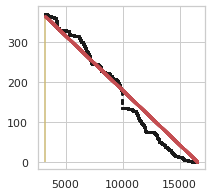

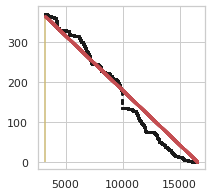

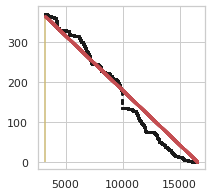

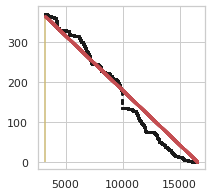

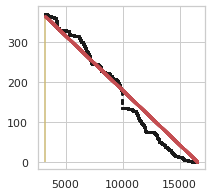

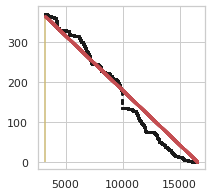

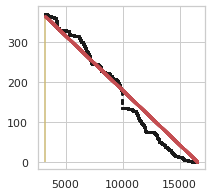

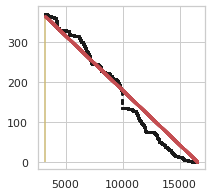

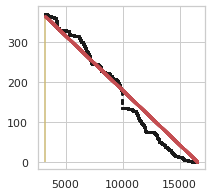

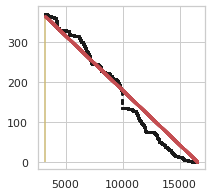

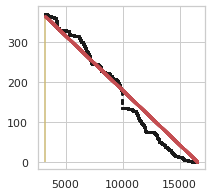

In [48]:
for g in genes_of_interest:
    rna_nascent_fit = rna_nascent_model(out[g+para2] ,None, [out[g+para1], model_loc_length])

    sns.set(style="whitegrid", color_codes=True,font_scale=1)
    f, ax = plt.subplots(figsize=(3, 3))          

    ax.errorbar(x=np.asarray(range(model_loc_start,model_loc_start+model_loc_length)), 
                y=rna_nascent[model_loc_start:], 
                fmt='o', ms=2,color='k') 
    ax.errorbar(x=np.asarray(range(model_loc_start,model_loc_start+model_loc_length)), 
                y=rna_nascent_fit, 
                fmt='o', ms=1,color='r') 

    plt.vlines(model_loc_start,ymin=0,ymax=max(rna_nascent[model_loc_start:]), color='y')
#     plt.vlines(rnr2_3end,ymin=0,ymax=max(rna_nascent))

#     for g in genes_of_interest:
#         end = max(gtf[gtf['gene_name']==g]['end'].values)
#         plt.vlines(end,ymin=0,ymax=max(rna_nascent), color='g')


    filename = 'Fig1K_elongation_rate_fit_F_from_gene_'+g+'.'
    plt.savefig(os.path.join(path,filename+'pdf'), bbox_inches="tight", transparent=True)
#     plt.savefig(os.path.join(path,filename+'tiff'), bbox_inches="tight", transparent=True, dpi=300)
#     plt.savefig(os.path.join(path,filename+'png'), bbox_inches="tight", transparent=True, dpi=300) 

# Plot main figure 1K: Nanopore RNA + model predictions

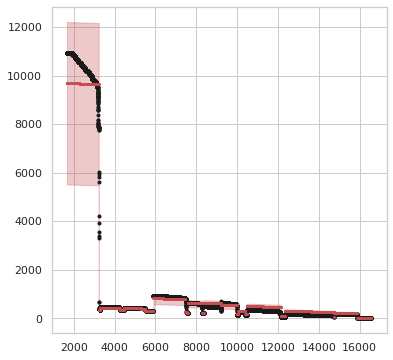

In [7]:
g_av = 'MT-RNR2'
plot_start = gtf[gtf['gene_name']==g_av]['start'].values[0] #TSS location set at 0

F_av = out[g_av + para1]
F_min = min(out[para1])
F_max = max(out[para1])
v_av = out[g_av + para2]
v_min = min(out[para2])
v_max = max(out[para2])

rna_nascent_fit_av = rna_nascent_model(v_av ,None, [F_av, (genome_len-plot_start)])
rna_pred_av = rna_model(rna_nascent_fit_av, F_av, plot_start)
rna_nascent_fit_min = rna_nascent_model(v_min ,None, [F_min, (genome_len-plot_start)])
rna_pred_min = rna_model(rna_nascent_fit_min, F_min, plot_start)
rna_nascent_fit_max = rna_nascent_model(v_max ,None, [F_max, (genome_len-plot_start)])
rna_pred_max = rna_model(rna_nascent_fit_max, F_max, plot_start)
    
sns.set(style="whitegrid", color_codes=True,font_scale=1)
f, ax = plt.subplots(figsize=(6, 6))          

ax.errorbar(x=np.asarray(range(plot_start,genome_len)), 
            y=rna[plot_start:], 
            fmt='o', ms=3,color='k')

ax.errorbar(x=np.asarray(range(plot_start,genome_len)), 
            y=rna_pred_av,              
            fmt='o', ms=1,color='r') 

plt.fill_between(np.asarray(range(plot_start,genome_len)), 
                 rna_pred_min, rna_pred_max, 
                 color='r',alpha=0.3)
    
     
    
filename = 'Fig1K_Nanopore_RNA_model_prediction.'
plt.savefig(os.path.join(path,filename+'pdf'), bbox_inches="tight", transparent=True)
# plt.savefig(os.path.join(path,filename+'tiff'), bbox_inches="tight", transparent=True, dpi=300)
# plt.savefig(os.path.join(path,filename+'png'), bbox_inches="tight", transparent=True, dpi=300) 


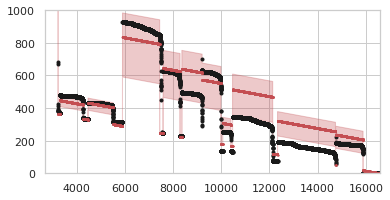

In [13]:
g_av = 'MT-RNR2'
plot_start = gtf[gtf['gene_name']==g_av]['start'].values[0] #TSS location set at 0

F_av = out[g_av + para1]
F_min = min(out[para1])
F_max = max(out[para1])
v_av = out[g_av + para2]
v_min = min(out[para2])
v_max = max(out[para2])

rna_nascent_fit_av = rna_nascent_model(v_av ,None, [F_av, (genome_len-plot_start)])
rna_pred_av = rna_model(rna_nascent_fit_av, F_av, plot_start)
rna_nascent_fit_min = rna_nascent_model(v_min ,None, [F_min, (genome_len-plot_start)])
rna_pred_min = rna_model(rna_nascent_fit_min, F_min, plot_start)
rna_nascent_fit_max = rna_nascent_model(v_max ,None, [F_max, (genome_len-plot_start)])
rna_pred_max = rna_model(rna_nascent_fit_max, F_max, plot_start)
    
sns.set(style="whitegrid", color_codes=True,font_scale=1)
f, ax = plt.subplots(figsize=(6, 3))          

ax.errorbar(x=np.asarray(range(plot_start,genome_len)), 
            y=rna[plot_start:], 
            fmt='o', ms=3,color='k')

ax.errorbar(x=np.asarray(range(plot_start,genome_len)), 
            y=rna_pred_av,               
            fmt='o', ms=1,color='r') 

plt.fill_between(np.asarray(range(plot_start,genome_len)), 
                 rna_pred_min, rna_pred_max, 
                 color='r',alpha=0.3)
    
plt.xlim([gtf[gtf['gene_name']==g_av]['start'].values[0]+1000, genome_len])
plt.ylim([0,1000])
# plt.xticks(time_measured)
# plt.yticks([i*0.1 for i in range(11)])     
    
filename = 'Fig1K_Nanopore_RNA_model_prediction_zoom.'
plt.savefig(os.path.join(path,filename+'pdf'), bbox_inches="tight", transparent=True)
# plt.savefig(os.path.join(path,filename+'tiff'), bbox_inches="tight", transparent=True, dpi=300)
# plt.savefig(os.path.join(path,filename+'png'), bbox_inches="tight", transparent=True, dpi=300) 
